In [8]:
#https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=vIWvJCpOVmwU
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
#from scipy.optimize import minimize
#from scipy import optimize
import pickle
#import statsmodels.api as sm
from math import ceil

from google.colab import drive
drive.mount("/content/drive")


from importlib import reload
import sys
sys.path.append('/content/drive/My Drive/ISE599Project_Phebe/Model')

import generate_dataset
import lstm_encoder_decoder
# import plotting 


Mounted at /content/drive


In [9]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        return out

In [11]:
# divide a long sequence into small pieces
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [3]:
def plot_train_test_results(lstm_model, Xtrain, Ytrain, Xtest, Ytest, num_rows = 3):
  '''
  plot examples of the lstm encoder-decoder evaluated on the training/test data
  
  : param lstm_model:     trained lstm encoder-decoder
  : param Xtrain:         np.array of windowed training input data
  : param Ytrain:         np.array of windowed training target data
  : param Xtest:          np.array of windowed test input data
  : param Ytest:          np.array of windowed test target data 
  : param num_rows:       number of training/test examples to plot
  : return:               num_rows x 2 plots; first column is training data predictions,
  :                       second column is test data predictions
  '''

  # input window size
  iw = Xtrain.shape[0]
  ow = Ytest.shape[0]

  # figure setup 
  num_cols = 2
  num_plots = num_rows * num_cols

  fig, ax = plt.subplots(num_rows, num_cols, figsize = (13, 15))
  
  # plot training/test predictions
  for ii in range(num_rows):
      # train set
      X_train_plt = Xtrain[:, ii, :]
      Y_train_pred = lstm_model.predict(torch.from_numpy(X_train_plt).type(torch.Tensor), target_len = ow)

      ax[ii, 0].plot(np.arange(0, iw), Xtrain[:, ii+ow, 0], 'k', linewidth = 2, label = 'Input')
      ax[ii, 0].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, ii+ow, 0]], Ytrain[:, ii+ow, 0]]),
                     color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
      ax[ii, 0].plot(np.arange(iw - 1, iw + ow),  np.concatenate([[Xtrain[-1, ii+ow, 0]], Y_train_pred[:, 0]]),
                     color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
      ax[ii, 0].set_xlim([0, iw + ow - 1])
      ax[ii, 0].set_xlabel('$t$')
      ax[ii, 0].set_ylabel('$y$')

      # test set
      X_test_plt = Xtest[:, ii, :]
      Y_test_pred = lstm_model.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)
      ax[ii, 1].plot(np.arange(0, iw), Xtest[:, ii+ow, 0], 'k', linewidth = 2, label = 'Input')
      ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, ii+ow, 0]], Ytest[:, ii+ow, 0]]),
                     color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
      ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, ii+ow, 0]], Y_test_pred[:, 0]]),
                     color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
      ax[ii, 1].set_xlim([0, iw + ow - 1])
      ax[ii, 1].set_xlabel('$t$')
      ax[ii, 1].set_ylabel('$y$')

      if ii == 0:
        ax[ii, 0].set_title('Train')
        
        ax[ii, 1].legend(bbox_to_anchor=(1, 1))
        ax[ii, 1].set_title('Test')

  plt.suptitle('LSTM Encoder-Decoder Predictions', x = 0.445, y = 1.)
  plt.tight_layout()
  plt.subplots_adjust(top = 0.95)
  # plt.savefig('plots/predictions.png')
  # plt.close() 

In [4]:
def plot_test_result(lstm_model, Xtest, Ytest, i,scaler):

  # input window size
  iw = Xtrain.shape[0]
  ow = Ytest.shape[0]

  X_test_plt = Xtest[:, i, :]
  Y_test_pred = lstm_model.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)

  plt.plot(np.arange(0, iw), scaler.inverse_transform(Xtest[:, i, :]), 'k', linewidth = 2, label = 'Input')
  plt.plot(np.arange(iw - 1, iw + ow), scaler.inverse_transform(np.concatenate([[Xtest[-1, i, :]], Ytest[:, i, :]])),
          color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
  plt.plot(np.arange(iw - 1, iw + ow), scaler.inverse_transform(np.concatenate([[Xtest[-1, i, :]], Y_test_pred[:, :]])),
          color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
  plt.xlim([0, iw + ow - 1])
  plt.xlabel('$t$')
  plt.ylabel('$y$')
  plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
hos_data = pickle.load( open( "/content/drive/My Drive/ISE599Project_Phebe/Data/new_hospitalized_data.p", "rb" ) )
hos_data_alhambra = hos_data[hos_data['geo_merge']=='Alhambra']
dates = [pd.to_datetime(i) - pd.to_datetime('2020-02-01')  for i in hos_data_alhambra['ep_date']]
dates = [i.days for i in dates]
dates = pd.Series(dates,index=hos_data_alhambra.index)
hos_data_alhambra['dates']=dates
hos_data_alhambra = hos_data_alhambra.sort_values(by=['dates'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Encoder-Decoder LSTM

In [ ]:
plt.rcParams.update({'font.size': 17})

In [5]:
daily_cases = hos_data_alhambra['hosp_14day'] 

test_data_size = 300
# len_train = 50
# forecast_len = 30 

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
train_data = np.expand_dims(train_data, axis=1)
test_data = np.expand_dims(test_data, axis=1)

NameError: ignored

In [ ]:
scaler = scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

100%|██████████| 500/500 [01:39<00:00,  5.03it/s, loss=0.000]


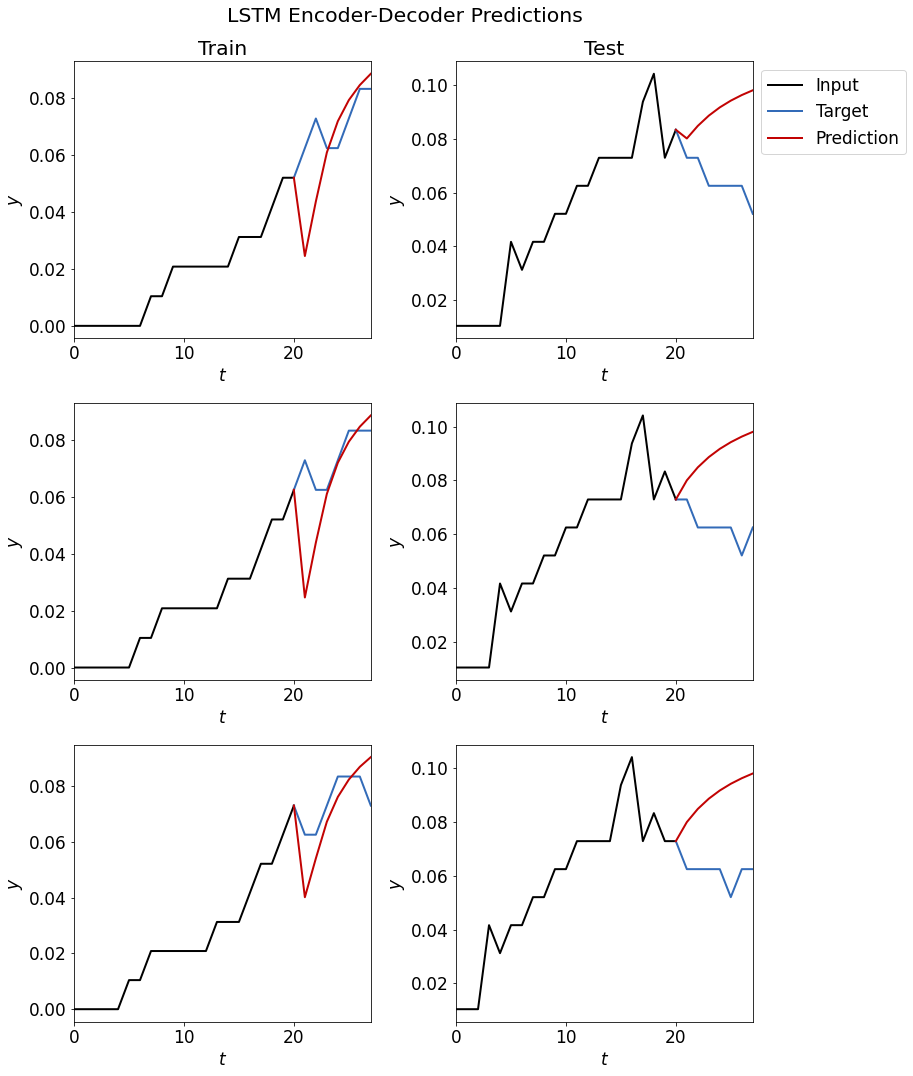

In [ ]:
# window dataset

# set size of input/output windows 
iw = 21 # input window
ow = 7 # output window
s = 1
# generate windowed training/test datasets
Xtrain, Ytrain= generate_dataset.windowed_dataset(train_data, input_window = iw, output_window = ow, stride = s)
Xtest, Ytest = generate_dataset.windowed_dataset(test_data, input_window = iw, output_window = ow, stride = s)
# convert windowed data from np.array to PyTorch tensor
X_train, Y_train, X_test, Y_test = generate_dataset.numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)
Xtrain7days = Xtrain
Ytrain7days = Ytrain
Xtest7days = Xtest
Ytest7days = Ytest

# specify model parameters and train
model7days = lstm_encoder_decoder.lstm_seq2seq(input_size = X_train.shape[2], hidden_size = 20)
loss = model7days.train_model(X_train, Y_train, n_epochs = 500, 
                         target_len = ow, batch_size = 21, 
                         training_prediction = 'mixed_teacher_forcing', 
                         teacher_forcing_ratio = 0.8, learning_rate = 0.02, dynamic_tf = False)

# plot predictions on train/test data
plot_train_test_results(model7days, Xtrain, Ytrain, Xtest, Ytest)



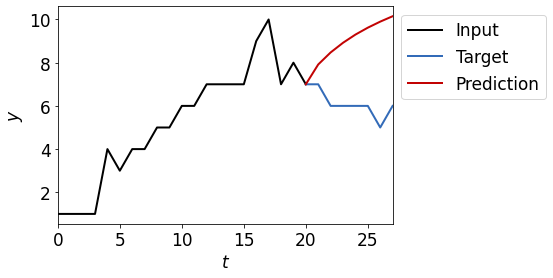

In [ ]:
i = 1
plot_test_result(model7days, Xtest7days, Ytest7days, i)

100%|██████████| 500/500 [01:47<00:00,  4.64it/s, loss=0.000]


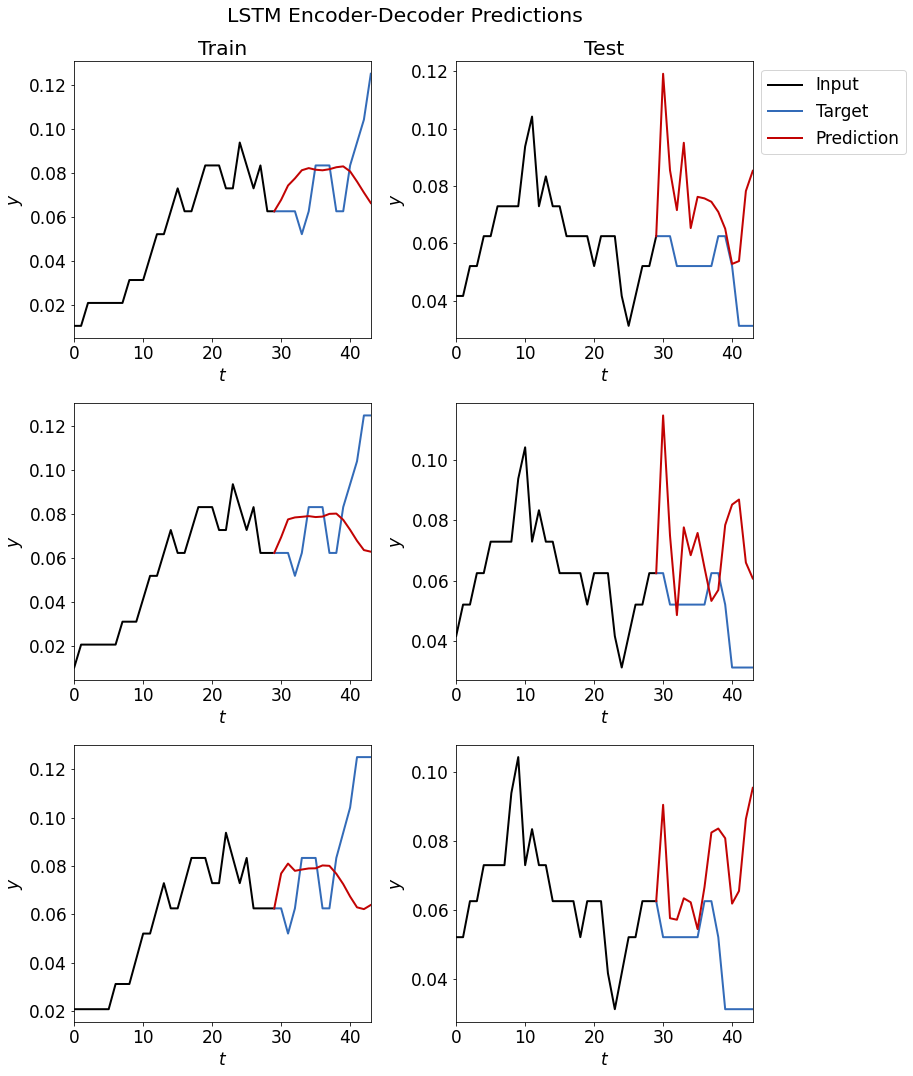

In [ ]:
# window dataset

# set size of input/output windows 
iw = 30 # input window
ow = 14 # output window
s = 1
# generate windowed training/test datasets
Xtrain, Ytrain= generate_dataset.windowed_dataset(train_data, input_window = iw, output_window = ow, stride = s)
Xtest, Ytest = generate_dataset.windowed_dataset(test_data, input_window = iw, output_window = ow, stride = s)
Xtrain14days = Xtrain
Ytrain14days = Ytrain
Xtest14days = Xtest
Ytest14days = Ytest
# LSTM encoder-decoder

# convert windowed data from np.array to PyTorch tensor
X_train, Y_train, X_test, Y_test = generate_dataset.numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)

# specify model parameters and train
model14days = lstm_encoder_decoder.lstm_seq2seq(input_size = X_train.shape[2], hidden_size = 15)
loss = model14days.train_model(X_train, Y_train, n_epochs = 500, 
                         target_len = ow, batch_size = 28, 
                         training_prediction = 'mixed_teacher_forcing', 
                         teacher_forcing_ratio = 0.7, learning_rate = 0.02, dynamic_tf = False)
plot_train_test_results(model14days, Xtrain, Ytrain, Xtest, Ytest)


100%|██████████| 500/500 [02:58<00:00,  2.81it/s, loss=0.000]


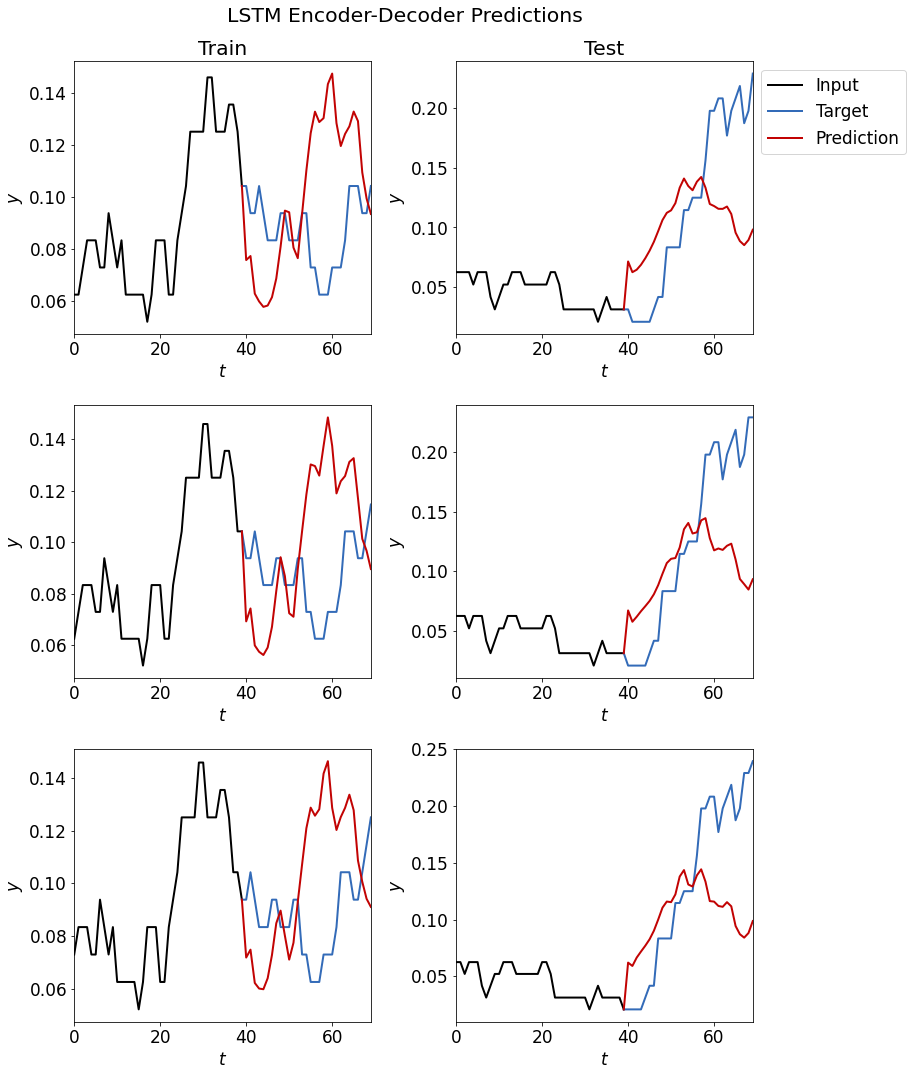

In [ ]:
# window dataset

# set size of input/output windows 
iw = 40 # input window
ow = 30 # output window
s = 1
# generate windowed training/test datasets
Xtrain, Ytrain= generate_dataset.windowed_dataset(train_data, input_window = iw, output_window = ow, stride = s)
Xtest, Ytest = generate_dataset.windowed_dataset(test_data, input_window = iw, output_window = ow, stride = s)
# LSTM encoder-decoder
Xtrain30days = Xtrain
Ytrain30days = Ytrain
Xtest30days = Xtest
Ytest30days = Ytest

# convert windowed data from np.array to PyTorch tensor
X_train, Y_train, X_test, Y_test = generate_dataset.numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)

# specify model parameters and train
model30days = lstm_encoder_decoder.lstm_seq2seq(input_size = X_train.shape[2], hidden_size = 20)
loss = model30days.train_model(X_train, Y_train, n_epochs = 500, 
                         target_len = ow, batch_size = 28, 
                         training_prediction = 'mixed_teacher_forcing', 
                         teacher_forcing_ratio = 0.7, learning_rate = 0.02, dynamic_tf = False)

plot_train_test_results(model30days, Xtrain, Ytrain, Xtest, Ytest)



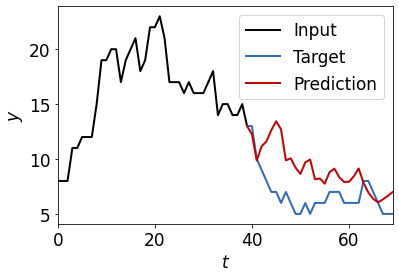

In [ ]:
plot_test_result(model30days, Xtest30days, Ytest30days, 50)

In [12]:
# hos_data = pickle.load( open( "/content/drive/My Drive/ISE599Project_Phebe/Data/new_hospitalized_data.p", "rb" ) )
district_data = pd.read_csv('/content/drive/My Drive/ISE599Project_Phebe/Data/hospitalization_data_nolbandpasa.csv',header=None)

# hos_data_alhambra = hos_data[hos_data['geo_merge']=='Alhambra']
# dates = [pd.to_datetime(i) - pd.to_datetime('2020-02-01')  for i in hos_data_alhambra['ep_date']]
# dates = [i.days for i in dates]
# dates = pd.Series(dates,index=hos_data_alhambra.index)
# hos_data_alhambra['dates']=dates
# hos_data_alhambra = hos_data_alhambra.sort_values(by=['dates'])

In [13]:
district_data

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
4,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,105.0,63.0,74.0,87.0,121.0,37.0,38.0,29.0,0.0,56.0,...,12.0,61.0,37.0,37.0,28.0,44.0,17.0,76.0,0.0,47.0
656,106.0,63.0,70.0,84.0,123.0,36.0,38.0,31.0,0.0,56.0,...,12.0,59.0,38.0,37.0,31.0,44.0,19.0,77.0,0.0,46.0
657,107.0,63.0,73.0,86.0,122.0,35.0,38.0,31.0,0.0,55.0,...,12.0,62.0,39.0,39.0,35.0,46.0,17.0,79.0,0.0,43.0
658,112.0,63.0,77.0,85.0,116.0,33.0,37.0,32.0,0.0,61.0,...,12.0,63.0,35.0,41.0,38.0,45.0,18.0,78.0,0.0,44.0


We want to predict the cases in day 300-314 and 525-539

In [14]:
daily_cases = district_data.iloc[:,1]
daily_cases

0       0.0
1       0.0
2       0.0
3       0.0
4       1.0
       ... 
655    63.0
656    63.0
657    63.0
658    63.0
659    67.0
Name: 1, Length: 660, dtype: float64

In [15]:
def prepare_data(data,start_day,scaler):
  train_data = daily_cases[:start_day]
  test_data = daily_cases[start_day:]
  train_data = np.expand_dims(train_data, axis=1)
  test_data = np.expand_dims(test_data, axis=1)

  scaler = scaler.fit(train_data)
  train_data = scaler.transform(train_data)
  test_data = scaler.transform(test_data)

  return train_data, test_data



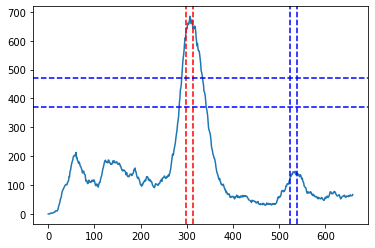

300    641.0
301    649.0
302    661.0
303    660.0
304    657.0
305    664.0
306    676.0
307    685.0
308    674.0
309    660.0
310    662.0
311    672.0
312    656.0
Name: 1, dtype: float64

In [16]:
plt.plot(daily_cases)
plt.axvline(x = 299, c='r', linestyle='--')
plt.axvline(x = 299+15, c='r', linestyle='--')
plt.axvline(x = 524, c='b', linestyle='--')
plt.axvline(x = 524+15, c='b', linestyle='--')
plt.axhline(y = 471, c='b', linestyle='--')
plt.axhline(y = 369, c='b', linestyle='--')
plt.show()
daily_cases[300:313]

In [17]:
daily_cases[524:524+14]

524    129.0
525    131.0
526    131.0
527    138.0
528    137.0
529    140.0
530    146.0
531    145.0
532    145.0
533    142.0
534    147.0
535    147.0
536    136.0
537    143.0
Name: 1, dtype: float64

100%|██████████| 500/500 [00:23<00:00, 21.12it/s, loss=0.000]


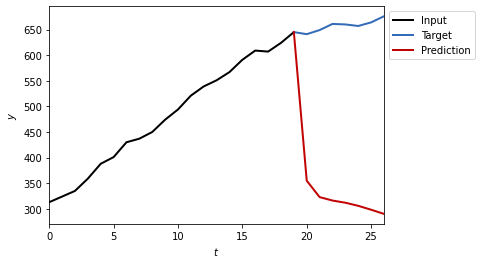

In [21]:
# window dataset
# set size of input/output windows 
iw = 20 # input window
ow = 7 # output window
s = 2
start_day = 300-iw  #+3 477 -1 470
train_data, test_data = prepare_data(daily_cases,start_day,scaler)
train_data.shape, test_data.shape

# generate windowed training/test datasets
Xtrain, Ytrain= generate_dataset.windowed_dataset(train_data, input_window = iw, output_window = ow, stride = s)
Xtest, Ytest = generate_dataset.windowed_dataset(test_data, input_window = iw, output_window = ow, stride = s)

# LSTM encoder-decoder

# convert windowed data from np.array to PyTorch tensor
X_train, Y_train, X_test, Y_test = generate_dataset.numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)

# specify model parameters and train
model14days = lstm_encoder_decoder.lstm_seq2seq(input_size = X_train.shape[2], hidden_size = 3)
loss = model14days.train_model(X_train, Y_train, n_epochs = 500, 
                         target_len = ow, batch_size = 30, 
                         training_prediction = 'mixed_teacher_forcing',#'mixed_teacher_forcing', #'teacher_forcing',#
                         teacher_forcing_ratio = 0.99, learning_rate = 0.02, dynamic_tf = False)
# plot_train_test_results(model14days, Xtrain, Ytrain, Xtest, Ytest)
plot_test_result(model14days, Xtest, Ytest, 0, scaler)


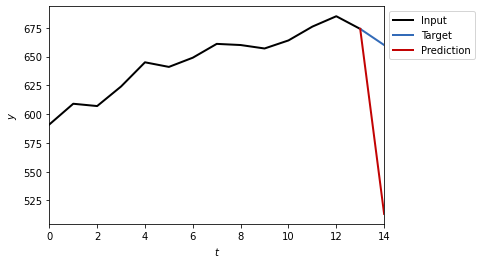

In [ ]:
plot_test_result(model14days, Xtest, Ytest, 3, scaler)

In [ ]:
scaler.inverse_transform(Ytest[:,0,:])

array([[641.],
       [649.]])

In [ ]:
X_test_plt = Xtest[:, 0, :]
Y_test_pred = model14days.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)
scaler.inverse_transform(Y_test_pred)

array([[604.433  ],
       [706.08484]], dtype=float32)

In [ ]:
scaler.inverse_transform(Xtest[:,0,:])

array([[430.],
       [437.],
       [450.],
       [474.],
       [494.],
       [521.],
       [539.],
       [551.],
       [567.],
       [591.],
       [609.],
       [607.],
       [624.],
       [645.]])

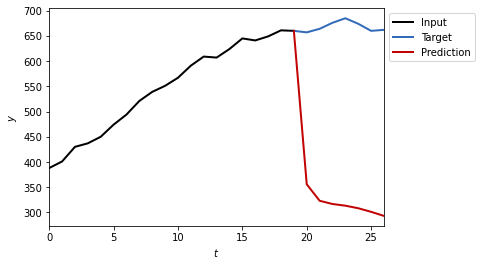

In [22]:
plot_test_result(model14days, Xtest, Ytest, 2, scaler)

In [23]:
X_test_plt = Xtest[:, 0, :]
Y_test_pred = model14days.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)
scaler.inverse_transform(Y_test_pred)

array([[354.9553 ],
       [322.93277],
       [316.24075],
       [311.97314],
       [305.94223],
       [298.3036 ],
       [290.1314 ]], dtype=float32)

In [24]:
scaler.inverse_transform(Ytest14days[:, 0, :])

NameError: ignored

In [25]:
Ytest14days.shape,Xtest14days.shape

NameError: ignored

100%|██████████| 1000/1000 [05:30<00:00,  3.03it/s, loss=0.000]


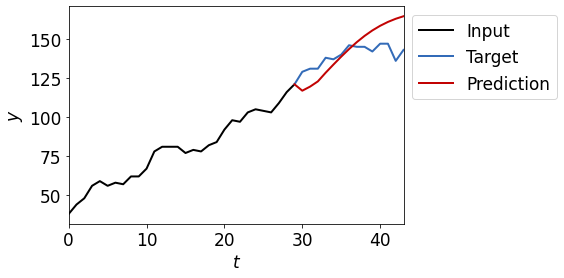

In [ ]:
# set size of input/output windows 
iw = 30 # input window
ow = 14 # output window
s = 1

start_day = 524-iw  #+3 477 -1 470
train_data, test_data = prepare_data(daily_cases,start_day,scaler)

# generate windowed training/test datasets
Xtrain, Ytrain= generate_dataset.windowed_dataset(train_data, input_window = iw, output_window = ow, stride = s)
Xtest, Ytest = generate_dataset.windowed_dataset(test_data, input_window = iw, output_window = ow, stride = s)

# LSTM encoder-decoder

# convert windowed data from np.array to PyTorch tensor
X_train, Y_train, X_test, Y_test = generate_dataset.numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)

# specify model parameters and train
model14days = lstm_encoder_decoder.lstm_seq2seq(input_size = X_train.shape[2], hidden_size = 20)
loss = model14days.train_model(X_train, Y_train, n_epochs = 1000, 
                         target_len = ow, batch_size = 20, 
                         training_prediction = 'teacher_forcing',#'mixed_teacher_forcing', 
                         teacher_forcing_ratio = 0.99, learning_rate = 0.02, dynamic_tf = False)
# plot_train_test_results(model14days, Xtrain, Ytrain, Xtest, Ytest)
plot_test_result(model14days, Xtest, Ytest, 0, scaler)

In [ ]:
scaler.inverse_transform(Ytest[:,0,:])

array([[129.],
       [131.],
       [131.],
       [138.],
       [137.],
       [140.],
       [146.],
       [145.],
       [145.],
       [142.],
       [147.],
       [147.],
       [136.],
       [143.]])

Conformal Prediction Interval

In [26]:
y_calb = np.zeros((Ytrain.shape[1],Ytrain.shape[0]))
for i in range(Ytrain.shape[1]):
  # yi = scaler.inverse_transform(Ytrain[:,i,:])
  yi = Ytrain[:,i,:]
  y_calb[i] = np.concatenate(yi,axis = None)

In [27]:
def find(x,alpha,data_len,fclen):
    idx = ceil((data_len+1)*((1)-alpha))
    return np.sort(np.array(x))[idx-1]

def CFLSTM(X,fclen,train_len,alpha,LSTM_pred):
    for i in range(fclen): #initalize epsilon
        globals()['eps%s' % i] = [] 
    lengthX = X.shape[1]
    y_pred = np.zeros((lengthX,fclen))
    for i in range(lengthX):
      X_test_plt = X[:, i, :]
      y_pred_i = LSTM_pred.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)
      y_pred[i] = np.concatenate([y_pred_i],axis = None) # y_pred[i] = LSTM_pred(X[:,i,:].reshape((1,train_len,1)),fclen,train_len).reshape(fclen,)
      for j in range(fclen):
        globals()['eps%s' % j].append(abs(y_pred[i,j]-y_calb[i,j]))

    #print(eps0)
    #Bonferroni and finite sample correction
    output = np.zeros(fclen)
    for t in range(fclen):
        output[t] = find(globals()['eps%s' % t],alpha,len(y_pred)-fclen,fclen)
    return output

In [28]:
Xtrain.shape
X_test_plt = Xtrain[:, i, :]
y_pred_i = model14days.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)

In [29]:
epshtrain = CFLSTM(Xtrain,ow,iw,0.005,model14days)
rps  = epshtrain.reshape((ow,1))

In [30]:
rps_array = np.concatenate([rps],axis = None)
rps_array

array([0.03424526, 0.05479596, 0.08034146, 0.10717893, 0.13428856,
       0.15847254, 0.18384314])

In [31]:
X_test_plt = Xtest[:, 0, :]
Y_test_pred = model14days.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)

predsl = np.concatenate([Y_test_pred],axis = None)-rps_array
predsu = np.concatenate([Y_test_pred],axis = None)+rps_array

scaler.inverse_transform(Y_test_pred)+scaler.inverse_transform(rps)
scaler.inverse_transform(rps)

array([[10.10235149],
       [16.16480798],
       [23.70072973],
       [31.61778486],
       [39.61512446],
       [46.74939823],
       [54.23372746]])

In [32]:
def plot_cp_result(lstm_model, Xtest, Ytest, i,scaler,rps):

  # input window size
  iw = Xtrain.shape[0]
  ow = Ytest.shape[0]

  X_test_plt = Xtest[:, i, :]
  Y_test_pred = lstm_model.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)

  plt.plot(np.arange(0, iw), scaler.inverse_transform(Xtest[:, i, :]), 'k', linewidth = 2, label = 'Input')
  plt.plot(np.arange(iw - 1, iw + ow), scaler.inverse_transform(np.concatenate([[Xtest[-1, i, :]], Ytest[:, i, :]])),
          color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
  plt.plot(np.arange(iw - 1, iw + ow), scaler.inverse_transform(np.concatenate([[Xtest[-1, i, :]], Y_test_pred[:, :]])),
          color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
  plt.plot(np.arange(iw - 1, iw + ow), scaler.inverse_transform(np.concatenate([[Xtest[-1, i, :]], Y_test_pred[:, :]+rps])),
          color = (0.5, 0.5, 0.01), linewidth = 2, label = 'Upperbound')
  plt.plot(np.arange(iw - 1, iw + ow), scaler.inverse_transform(np.concatenate([[Xtest[-1, i, :]], Y_test_pred[:, :]-rps])),
          color = (0.5, 0.5, 0.01), linewidth = 2, label = 'Lowerbound')
  plt.xlim([0, iw + ow - 1])
  plt.xlabel('$t$')
  plt.ylabel('$y$')
  plt.legend(bbox_to_anchor=(1, 1))

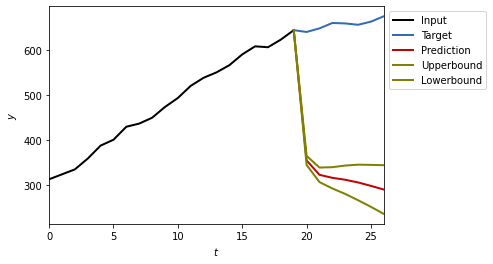

In [33]:
plot_cp_result(model14days, Xtest, Ytest, 0,scaler,rps)

In [ ]:

i = 0
X_test_plt = Xtest[:, i, :]
Y_test_pred = model14days.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)

predict = scaler.inverse_transform(Y_test_pred[:, :])
true = scaler.inverse_transform(Ytest[:, i, :])
error = scaler.inverse_transform(Ytest[:, i, :]-Y_test_pred[:, :])
upper = scaler.inverse_transform(Y_test_pred[:, :]+rps)
lower = scaler.inverse_transform(Y_test_pred[:, :]-rps)

name = [ 'true','predict','error','upper','lower']

NameError: ignored

In [ ]:
Area = {}
Area[1] = pd.DataFrame(list(zip(true,predict,error,upper,lower)),columns=name)
Area[2] = pd.DataFrame(list(zip(true,predict,error)))

Xtest_all = {}
Xtest_all[1] = scaler.inverse_transform(Xtest[:, 0, :])

100%|██████████| 1000/1000 [01:48<00:00,  9.18it/s, loss=0.000]


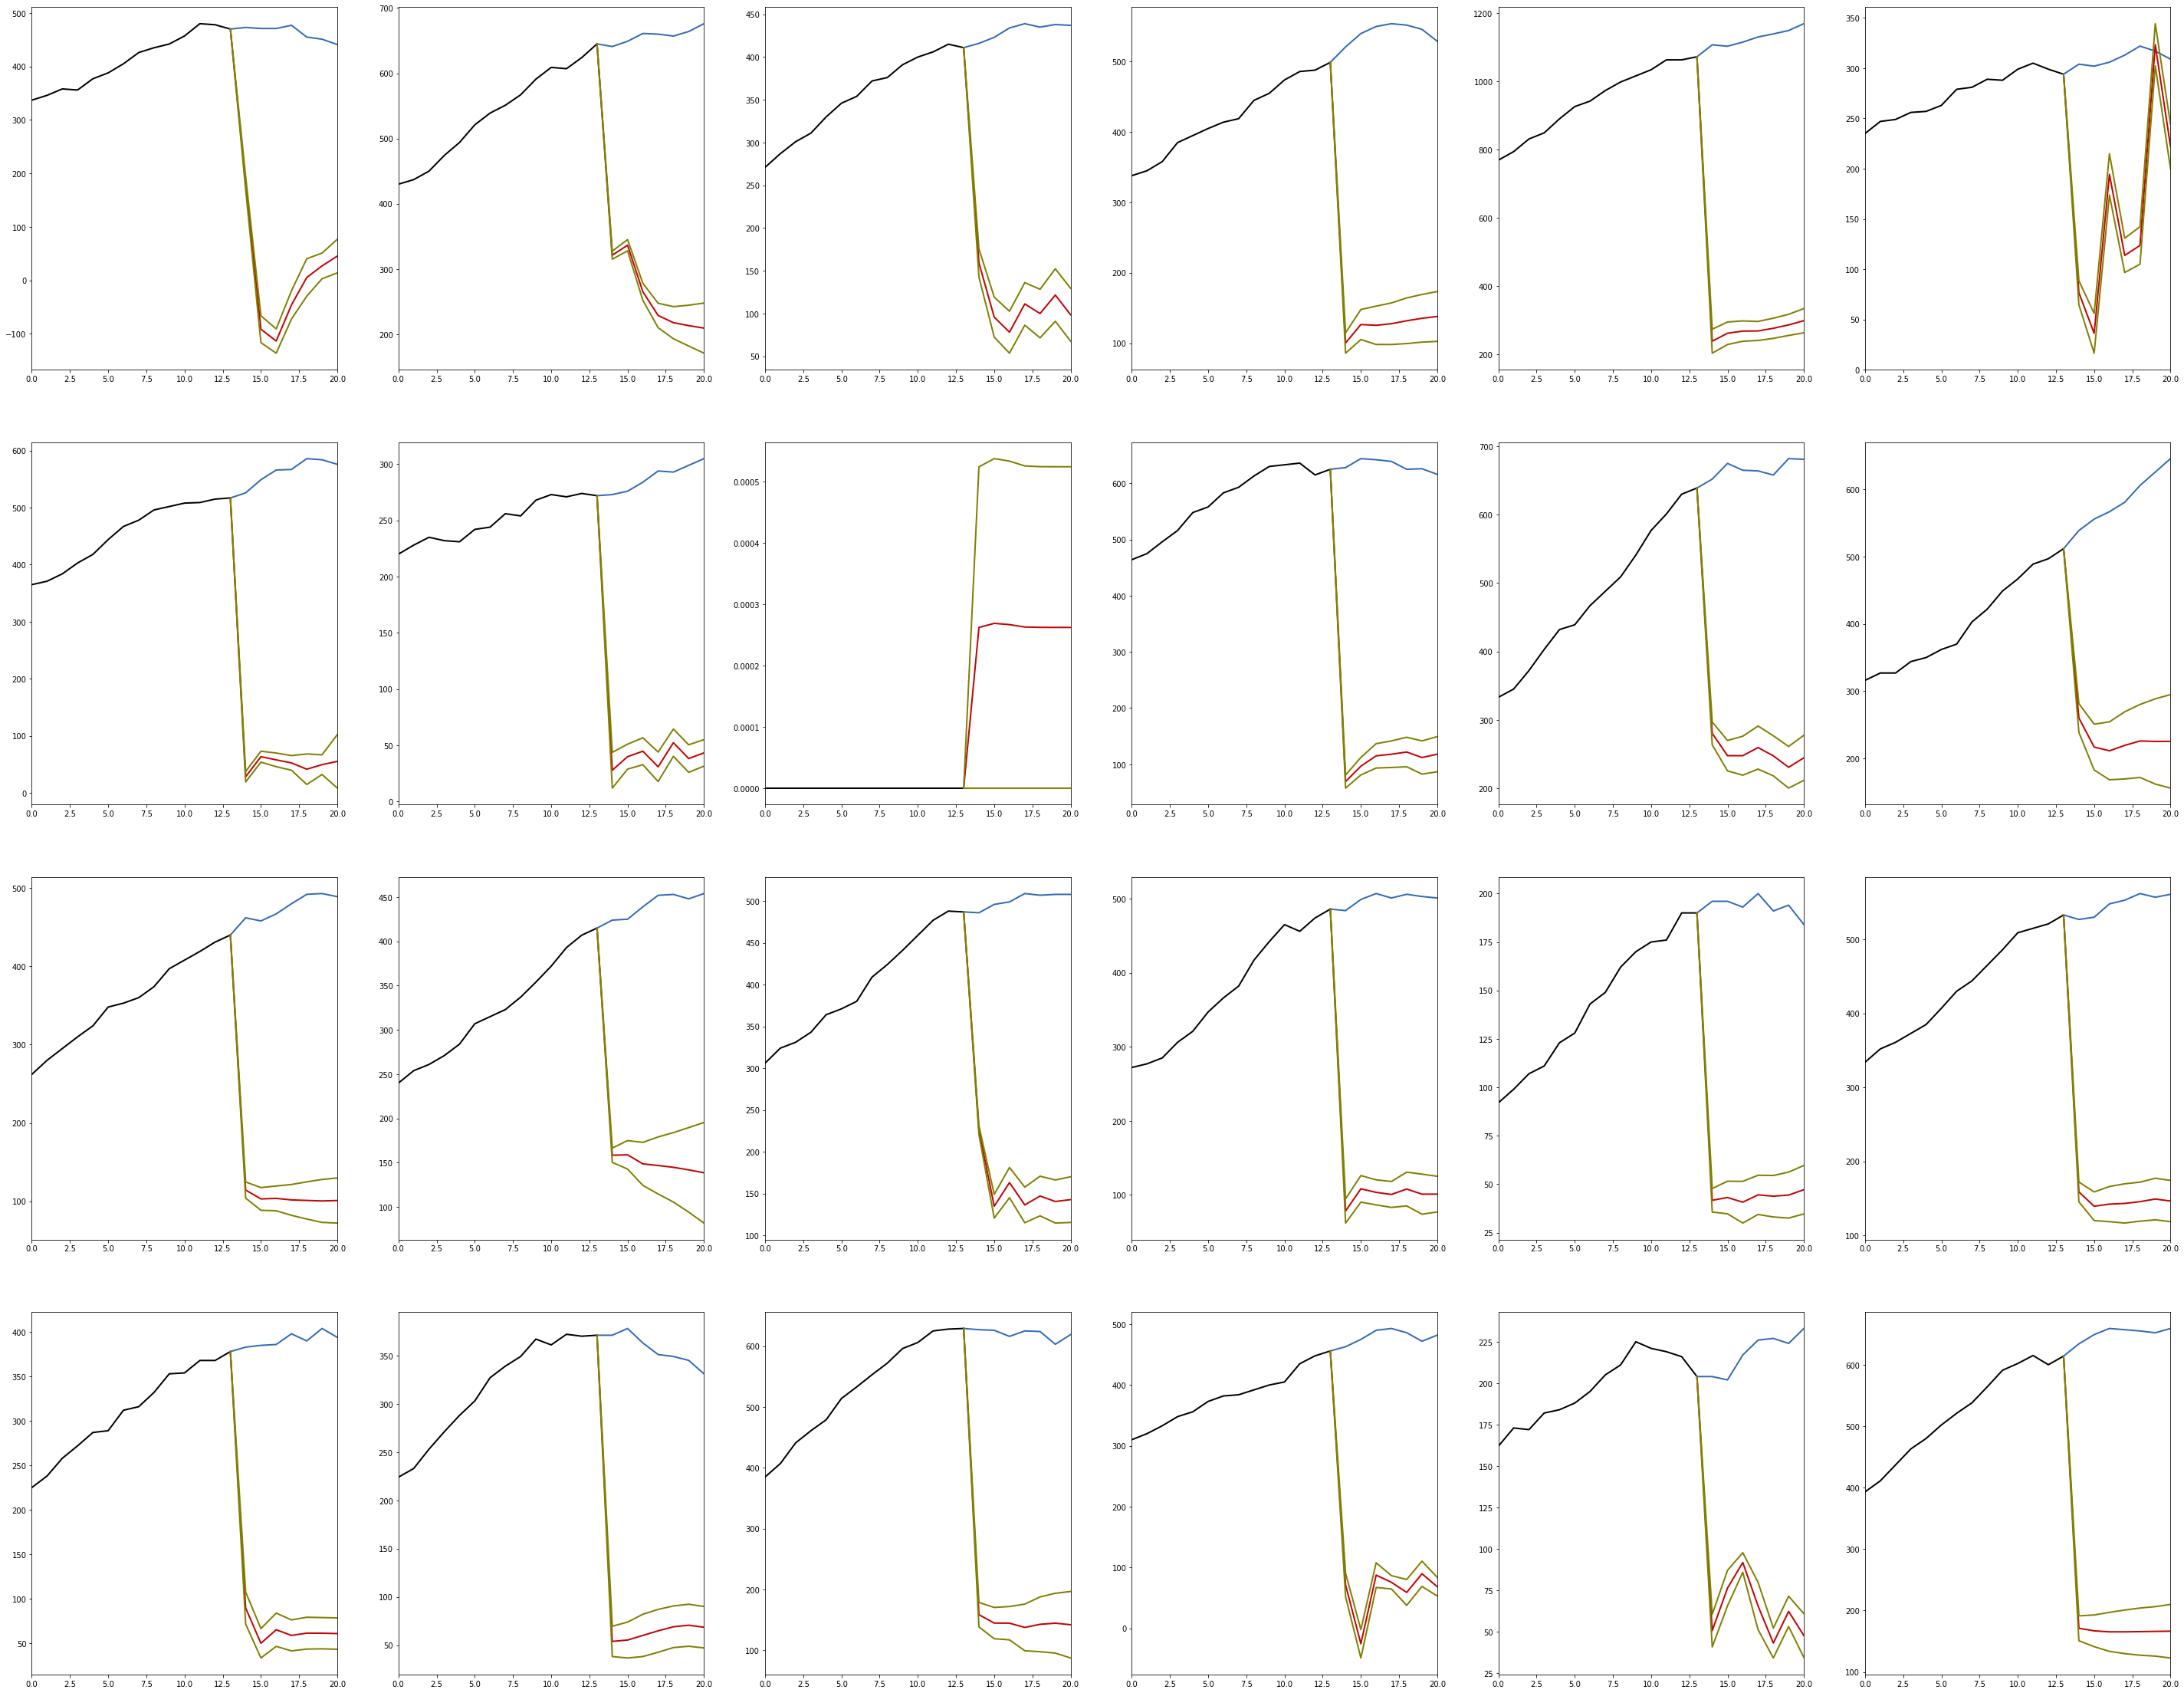

In [ ]:
name = [ 'true','predict','error','upper','lower']
Area = {}
Xtest_all = {}
fig, ax = plt.subplots(4,6,figsize=(50, 40))
# set size of input/output windows
iw = 14 # input window # 30 for 525
ow = 7 # output window
s = 1

pi,pj=0,0
PLOTS_PER_ROW = 6

for di in range(24):
  daily_cases = district_data.iloc[:,di]
  start_day = 300-iw  
  train_data, test_data = prepare_data(daily_cases,start_day,scaler)
  
  # generate windowed training/test datasets
  Xtrain, Ytrain= generate_dataset.windowed_dataset(train_data, input_window = iw, output_window = ow, stride = s)
  Xtest, Ytest = generate_dataset.windowed_dataset(test_data, input_window = iw, output_window = ow, stride = s)
  
  # convert windowed data from np.array to PyTorch tensor
  X_train, Y_train, X_test, Y_test = generate_dataset.numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)
  
  # specify model parameters and train
  model14days = lstm_encoder_decoder.lstm_seq2seq(input_size = X_train.shape[2], hidden_size = 20)
  loss = model14days.train_model(X_train, Y_train, n_epochs = 1000, 
                         target_len = ow, batch_size = 20, 
                         training_prediction = 'teacher_forcing',#'mixed_teacher_forcing', 
                         teacher_forcing_ratio = 0.999, learning_rate = 0.02, dynamic_tf = False)
  # plot_test_result(model14days, Xtest, Ytest, 0, scaler)

  y_calb = np.zeros((Ytrain.shape[1],Ytrain.shape[0]))
  for i in range(Ytrain.shape[1]):
    yi = Ytrain[:,i,:]
    y_calb[i] = np.concatenate(yi,axis = None)

  epshtrain = CFLSTM(Xtrain,ow,iw,0.5,model14days)
  rps  = epshtrain.reshape((ow,1))
  
  X_test_plt = Xtest[:, 0, :]
  Y_test_pred = model14days.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)
  
  predict = scaler.inverse_transform(Y_test_pred[:, :])
  true = scaler.inverse_transform(Ytest[:, 0, :])
  error = scaler.inverse_transform(Ytest[:, 0, :]-Y_test_pred[:, :])
  upper = scaler.inverse_transform(Y_test_pred[:, :]+rps)
  lower = scaler.inverse_transform(Y_test_pred[:, :]-rps)

  Area[di] = pd.DataFrame(list(zip(true,predict,error,upper,lower)),columns=name)
  Xtest_all[di] = scaler.inverse_transform(Xtest[:, 0, :])

  ax[pi][pj].plot(np.arange(0, iw), scaler.inverse_transform(Xtest[:, 0, :]), 'k', linewidth = 2, label = 'Input')
  ax[pi][pj].plot(np.arange(iw - 1, iw + ow), scaler.inverse_transform(np.concatenate([[Xtest[-1, 0, :]], Ytest[:, 0, :]])),
          color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
  ax[pi][pj].plot(np.arange(iw - 1, iw + ow), scaler.inverse_transform(np.concatenate([[Xtest[-1, 0, :]], Y_test_pred[:, :]])),
          color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
  ax[pi][pj].plot(np.arange(iw - 1, iw + ow), scaler.inverse_transform(np.concatenate([[Xtest[-1, 0, :]], Y_test_pred[:, :]+rps])),
          color = (0.5, 0.5, 0.01), linewidth = 2, label = 'Upperbound')
  ax[pi][pj].plot(np.arange(iw - 1, iw + ow), scaler.inverse_transform(np.concatenate([[Xtest[-1, 0, :]], Y_test_pred[:, :]-rps])),
          color = (0.5, 0.5, 0.01), linewidth = 2, label = 'Lowerbound')
  ax[pi][pj].set_xlim([0, iw + ow - 1])
  
  pj+=1
  if pj%PLOTS_PER_ROW==0:
    pi+=1
    pj=0


In [ ]:
pickle.dump(Area, open("/content/drive/My Drive/ISE599Project_Phebe/Data/Area24_300_7.p", "wb"))
pickle.dump(Xtest_all, open("/content/drive/My Drive/ISE599Project_Phebe/Data/Xtest24_300_7.p", "wb"))

No handles with labels found to put in legend.


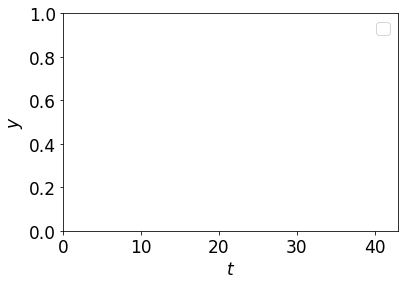

In [ ]:
def plot_test_result(lstm_model, Xtest, Ytest, i,scaler):

  # input window size
  iw = Xtrain.shape[0]
  ow = Ytest.shape[0]

  X_test_plt = Xtest[:, i, :]
  Y_test_pred = lstm_model.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)

  plt.plot(np.arange(0, iw), scaler.inverse_transform(Xtest[:, i, :]), 'k', linewidth = 2, label = 'Input')
  plt.plot(np.arange(iw - 1, iw + ow), scaler.inverse_transform(np.concatenate([[Xtest[-1, i, :]], Ytest[:, i, :]])),
          color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
  plt.plot(np.arange(iw - 1, iw + ow), scaler.inverse_transform(np.concatenate([[Xtest[-1, i, :]], Y_test_pred[:, :]])),
          color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
  plt.xlim([0, iw + ow - 1])
  plt.xlabel('$t$')
  plt.ylabel('$y$')
  plt.legend(bbox_to_anchor=(1, 1))